In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=False, download=True, transform=transforms.ToTensor())

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 5

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=7, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=False, num_workers=7, pin_memory=use_cuda)

In [4]:
def nets(size): 
    hidden_f = 1   
    return nn.Sequential(nn.Linear(size, size*hidden_f),
                         nn.ReLU(True), 
#                          nn.Linear(size*hidden_f, size*hidden_f), 
#                          nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size),
                         nn.Sigmoid())

def nett(size):
    hidden_f = 1
    return nn.Sequential(nn.Linear(size, size*hidden_f),
                         nn.ReLU(True), 
#                          nn.Linear(size*hidden_f, size*hidden_f),  
#                          nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size))

class CouplingLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        self.scale = nets(self.size)
        self.reverse = reverse
        
    def forward(self, args):
        x, log_det_J = args
        x1, x2 = torch.split(x, self.size, 1)
#         if self.reverse:
#             x2, x1 = x1, x2
        s = self.scale(x1)
        t = self.translate(x1)
        y2 = x2 * torch.exp(s) + t
        y = torch.cat((x1, y2), 1)
        log_det_J += s.sum(dim=1)
        return y, log_det_J

    def inverse(self, y):
        y1, y2 = torch.split(y, self.size, 1)
#         if self.reverse:
#             y2, y1 = y1, y2        
        s = self.scale(y1)
        t = self.translate(y1)
        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat((y1, x2), 1) 
    
class CouplingLayer_nice(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        self.reverse = reverse
        
    def forward(self, x):
        x1, x2 = torch.split(x, self.size, 1)
#         if self.reverse:
#             x2, x1 = x1, x2        
        t = self.translate(x1)
        y2 = x2 + t
        return torch.cat((x1, y2), 1)

    def inverse(self, y):
        y1, y2 = torch.split(y, self.size, 1)
#         if self.reverse:
#             y2, y1 = y1, y2          
        t = self.translate(y1)
        x2 = y2 - t
        return torch.cat((y1, x2), 1)
    
class HH(nn.Module):
    def __init__(self, size, num_vectors=None):
        super().__init__()
        self.size = size
        self.num_vectors = num_vectors or 2 * (self.size // 2 + 1)
        self.vectors = nn.Parameter(torch.Tensor(self.num_vectors, self.size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.vectors, -1, 1)
        self.vectors.data.copy_(self.vectors / self.vectors.norm(dim=1, keepdim=True))

    def forward(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q.t()

    def inverse(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q

    # Householder transformation
    def _get_bmm_householder_matrices(self):
        N, S, _ = self.vectors.size()

        outer = torch.bmm(self.vectors, self.vectors.transpose(1, 2))
        inner = torch.bmm(self.vectors.transpose(1, 2), self.vectors)
        I = torch.eye(S, device=self.vectors.device).expand(N, -1, -1)
        hh_matrices = I - 2 * outer / (inner + 1e-16)
        return hh_matrices

    @staticmethod
    def _reduce_mm(matrices):
        Q = matrices[0]
        for M in matrices[1:]:
            Q = torch.mm(Q, M)
        return Q


    def bmm_naive_cascade(self):
        """
        Args:   
            vectors: [NumVectors, Size, 1]
        Output:
            Q: [Size, Size]
        """
        matrices = self._get_bmm_householder_matrices()
        return HH._reduce_mm(matrices)

In [5]:
class RealNVP(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(CouplingLayer(size),
                                     HH(size, 20),
                                     CouplingLayer(size, True),
                                     HH(size, 20),
                                     CouplingLayer(size), 
                                     HH(size, 20),
                                     CouplingLayer(size, True),
                                     HH(size, 20),
                                     CouplingLayer(size), 
                                     HH(size, 20),
                                     CouplingLayer(size, True))
    
    def forward(self, x):
        log_det_J = x.new_zeros(x.shape[0])
        for layer in self.encoder:
            if isinstance(layer, CouplingLayer):
                x, log_det_J = layer((x, log_det_J))
            else:
                x = layer(x)
        return x, log_det_J
    
    def inverse(self, y):
        for layer in reversed(self.encoder):
            y = layer.inverse(y) 
        return y
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.inverse(y)
    
    def log_prob(self, x):
        y, logp = self(x)
        return self.prior.log_prob(y) - logp
    
class Nice(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(CouplingLayer_nice(size), 
                                     HH(size, 20),
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     HH(size, 20),
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     HH(size, 20),
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     HH(size, 20),
                                     CouplingLayer_nice(size, True))
    
    def forward(self, x):
        return self.encoder(x)   
    
    def inverse(self, y):
        for layer in reversed(self.encoder):
            y = layer.inverse(y) 
        return y
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.inverse(y)
    
    def log_prob(self, x):
        y = self(x)
        return self.prior.log_prob(y)    

In [6]:
def train(network):
    net = network(IM_SIZE).to(device).train()
    optimizer = optim.Adam(net.parameters())

    for epoch in range(EPOCHS):
        for X, _ in trainset:
#             plt.imshow(X[0,0])
#             plt.show()
            X = X.view(-1, IM_SIZE).to(device)
            optimizer.zero_grad()
            loss = -net.log_prob(X).mean()
            
#             plt.imshow(net.inverse(net(X))[0].cpu().detach().view(IM_SHAPE))
#             plt.show()
            
            loss.backward(retain_graph=True)
            optimizer.step()  
#             break
#         break
        print(epoch, loss)
    
    return net

In [7]:
net_RealNVP = train(Nice)


0 tensor(722.7950, device='cuda:0', grad_fn=<NegBackward>)
1 tensor(722.2667, device='cuda:0', grad_fn=<NegBackward>)
2 tensor(721.9244, device='cuda:0', grad_fn=<NegBackward>)
3 tensor(721.6623, device='cuda:0', grad_fn=<NegBackward>)
4 tensor(721.7667, device='cuda:0', grad_fn=<NegBackward>)


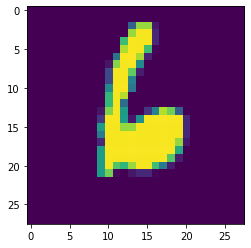

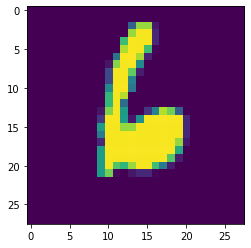

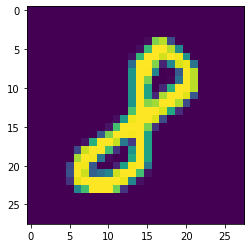

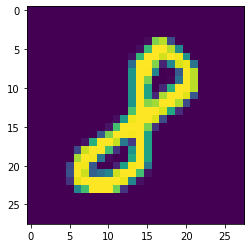

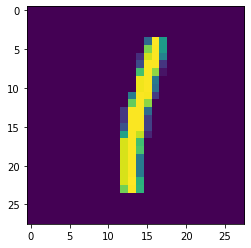

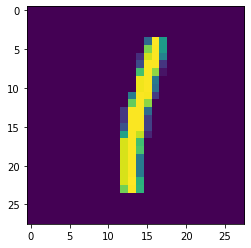

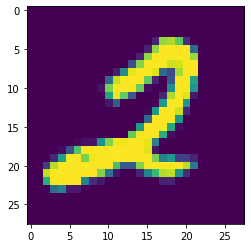

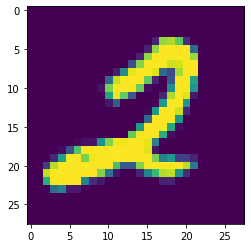

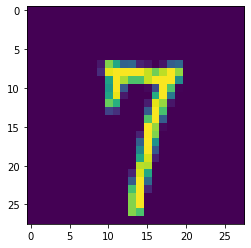

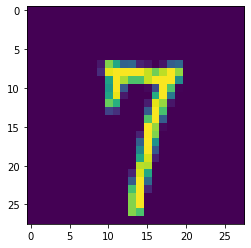

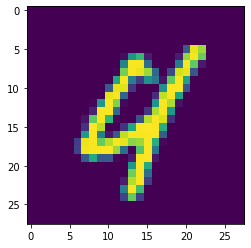

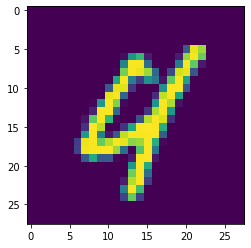

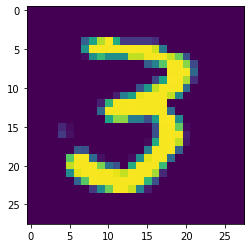

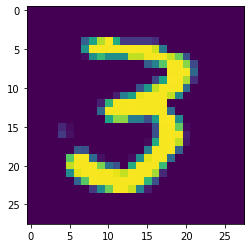

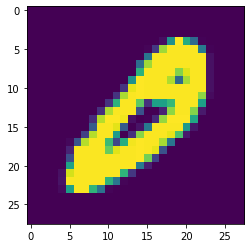

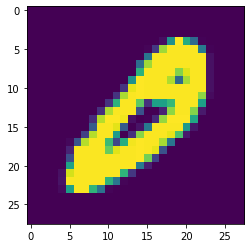

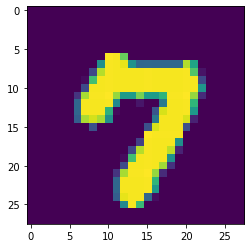

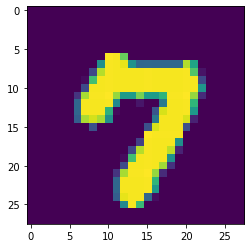

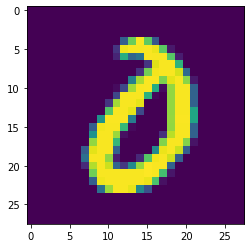

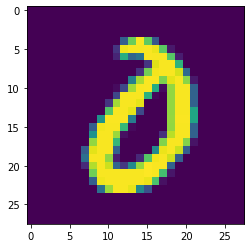

In [8]:

net_RealNVP.eval()
for X, _ in testset:
    X = X[:10].view(-1, IM_SIZE).to(device)
    y = net_RealNVP(X)
    x = net_RealNVP.inverse(y)
    break
    
for i, im in enumerate(x):  
    plt.imshow(X[i].cpu().view(IM_SHAPE).detach().numpy())
    plt.show()    
    plt.imshow(im.cpu().view(IM_SHAPE).detach().numpy())
    plt.show()

In [11]:
def test(net):
    net.eval()
    comp_data = np.empty((10000, 784))
    comp_label = np.empty((10000,))
    loss = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testset):
            X = X.view(-1, IM_SIZE).to(device)
            latent = net(X)
            output = net.inverse(latent)
            comp_data[BATCH * i: BATCH * (i + 1)] = latent.cpu()
            comp_label[BATCH * i: BATCH * (i + 1)] = y

            loss += F.mse_loss(output, X)

    print(loss / (i + 1))
    if use_cuda:
        X = X.cpu()
        output = output.cpu()
        
    plt.subplot(141)
    plt.imshow(X[0].view(IM_SHAPE))
    plt.subplot(142)
    plt.imshow(comp_data[0].reshape(IM_SHAPE))
    plt.subplot(143)
    plt.imshow(output[0].view(IM_SHAPE))
    plt.tight_layout()
    plt.show()
    
    return comp_data, comp_label

tensor(3.1210e-12, device='cuda:0')


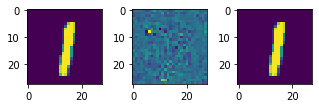

(array([[-0.02294022,  0.01412178,  0.00379099, ...,  0.01887227,
         -0.06293795, -0.03889549],
        [-0.0595291 ,  0.01690475, -0.08539272, ..., -0.03694597,
          0.05431555, -0.00348487],
        [ 0.02515876, -0.00806086,  0.01698587, ...,  0.03826472,
         -0.01057565, -0.00014365],
        ...,
        [ 0.0480707 ,  0.04390032,  0.00058617, ...,  0.00163994,
         -0.04263113, -0.00597595],
        [-0.01371665,  0.07017686,  0.04285567, ...,  0.03879405,
         -0.08872428, -0.0227288 ],
        [-0.04482673, -0.07438594, -0.02901376, ...,  0.04204324,
          0.02721458, -0.02464484]]),
 array([7., 2., 1., ..., 4., 5., 6.]))

In [12]:
test(net_RealNVP)

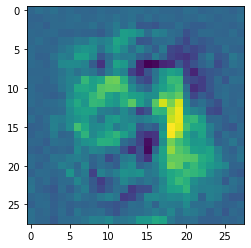

In [13]:
net_RealNVP.eval()
X = net_RealNVP.sample().cpu()
plt.imshow(X[0].view(IM_SHAPE).detach().numpy())

In [14]:
net_RealNVP.eval()
SAMPLES = 10
X = net_RealNVP.sample(SAMPLES).cpu()
for i in range(SAMPLES):
    plt.imshow(X[i].view(IM_SHAPE).detach().numpy())
    plt.show()
    

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 4.00 GiB total capacity; 2.91 GiB already allocated; 44.85 MiB free; 2.99 GiB reserved in total by PyTorch)